In [119]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
import os       
import shutil
import random
import PIL
import seaborn as sns

In [120]:
data_dir = "/Users/lukas/GitHub/rescue_maze_2024/vision/source/"

In [125]:
batch_size = 32
img_height = 25
img_width = 25
seed = 1337
v_split = 0.5


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=v_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=v_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3331 files belonging to 4 classes.


Using 1666 files for training.
Found 3331 files belonging to 4 classes.
Using 1665 files for validation.


In [126]:
#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
#data_dir = pathlib.Path(archive).with_suffix('')
#print(data_dir)

In [127]:
class_names = train_ds.class_names
print(class_names)

['H', 'S', 'U', 'none']


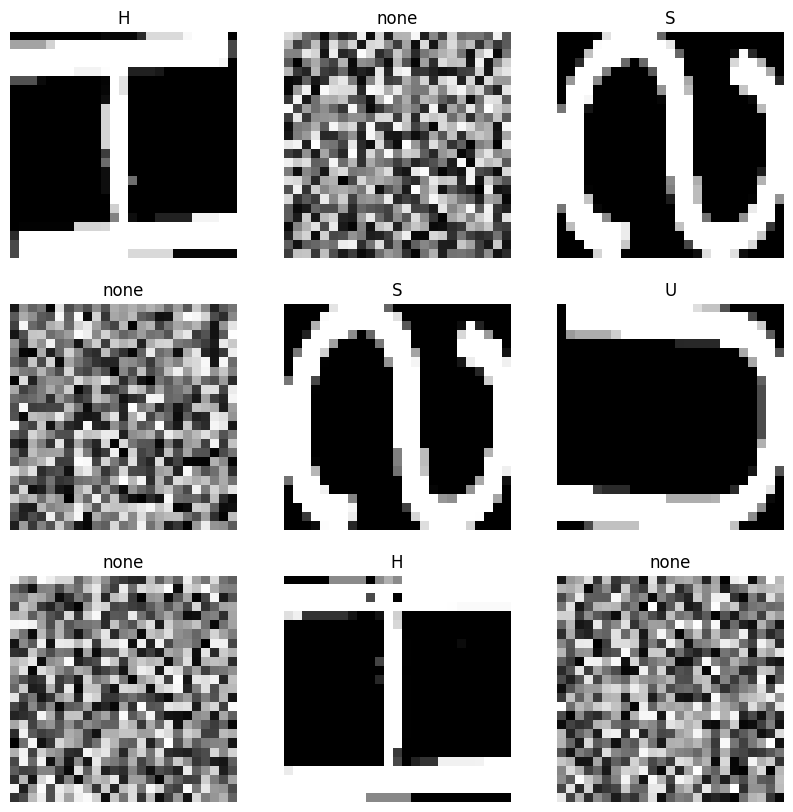

In [128]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

Text(0.5, 1.0, 'count')

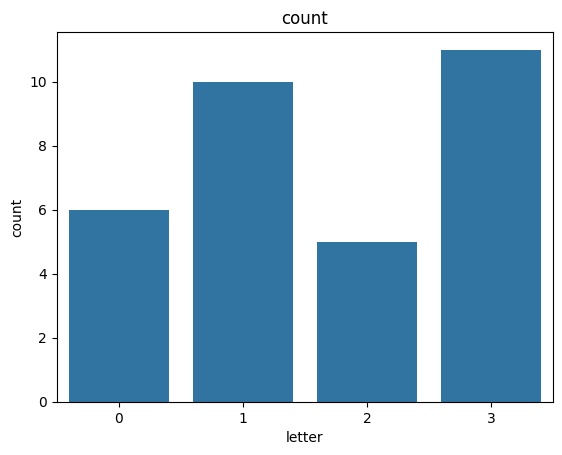

In [129]:
sns.countplot(x=labels.numpy())
plt.xlabel('letter')
plt.title("count")

In [130]:
def create_model():
  num_classes = 4
  model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
  ])
  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
  return model 
model = create_model()


In [131]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
53/53 [==============================] - 1s 9ms/step - loss: 0.0690 - accuracy: 0.9718 - val_loss: 3.9537e-05 - val_accuracy: 1.0000
Epoch 2/20
53/53 [==============================] - 0s 7ms/step - loss: 2.9752e-05 - accuracy: 1.0000 - val_loss: 1.8916e-05 - val_accuracy: 1.0000
Epoch 3/20
53/53 [==============================] - 0s 8ms/step - loss: 1.7735e-05 - accuracy: 1.0000 - val_loss: 1.2890e-05 - val_accuracy: 1.0000
Epoch 4/20
53/53 [==============================] - 0s 9ms/step - loss: 1.2989e-05 - accuracy: 1.0000 - val_loss: 9.5833e-06 - val_accuracy: 1.0000
Epoch 5/20
53/53 [==============================] - 1s 10ms/step - loss: 1.0141e-05 - accuracy: 1.0000 - val_loss: 7.5037e-06 - val_accuracy: 1.0000
Epoch 6/20
53/53 [==============================] - 0s 8ms/step - loss: 8.2122e-06 - accuracy: 1.0000 - val_loss: 6.0610e-06 - val_accuracy: 1.0000
Epoch 7/20
53/53 [==============================] - 0s 7ms/step - loss: 6.8069e-06 - accuracy: 1.0000 - val_loss: 4

In [132]:
model.save_weights('./checkpoints/my_checkpoint')

In [133]:
model2 = create_model()
model2.load_weights('./checkpoints/my_checkpoint').expect_partial()
loss, acc = model2.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

#model2.predict_proba(x=)

53/53 - 0s - loss: 5.5259e-07 - accuracy: 1.0000 - 266ms/epoch - 5ms/step
Restored model, accuracy: 100.00%


In [134]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/5c/9kv0yjyx7n54710xzsy97_rc0000gn/T/tmp9ve_wntf/assets


INFO:tensorflow:Assets written to: /var/folders/5c/9kv0yjyx7n54710xzsy97_rc0000gn/T/tmp9ve_wntf/assets
2024-04-11 16:08:58.609693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-04-11 16:08:58.609850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-04-11 16:08:58.610367: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/5c/9kv0yjyx7n54710xzsy97_rc0000gn/T/tmp9ve_wntf
2024-04-11 16:08:58.611083: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-04-11 16:08:58.611089: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/5c/9kv0yjyx7n54710xzsy97_rc0000gn/T/tmp9ve_wntf
2024-04-11 16:08:58.613912: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-04-11 16:08:58.651053: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

In [135]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
                                         

In [136]:
import cv2
path = "/Users/lukas/GitHub/rescue_maze_2024/vision/source/U/U42.png"
file = cv2.imread(path)
file = cv2.resize(file,(25,25))
#file = file/255
file = np.float32(file)
file = np.expand_dims(file, axis=0)
print(file.shape)
print(file.dtype)
predictions = probability_model.predict(file)

(1, 25, 25, 3)
float32
1/1 [==============================] - 0s 265ms/step


In [137]:
print(predictions)
np.argmax(predictions[0])
class_names[np.argmax(predictions[0])]

[[1.0416352e-06 3.4138381e-07 9.9999845e-01 1.1092986e-07]]


'U'

In [87]:

predictions = probability_model.predict(val_ds)

37/37 [==============================] - 0s 5ms/step
